In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    port='3307',
    user='root',
    password='root',
    database='project'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/rajva/OneDrive/Desktop/cons/ecommerce/data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sea
import mysql.connector

db = mysql.connector.connect(
    host='127.0.0.1',
    port='3307',
    user='root',
    password='root',
    database='project'
)

cur = db.cursor()

# 1.List all unique cities where customers are located. 


In [4]:
query = """ SELECT DISTINCT customer_city  FROM customers order by customer_city """

cur.execute(query)

data = cur.fetchall()

data 
df = pd.DataFrame(data,columns = ["city"])
df

,city
0,abadia dos dourados
1,abadiania
2,abaete
3,abaetetuba
4,abaiara
...,...
4114,xinguara
4115,xique-xique
4116,zacarias
4117,ze doca


# 2.Count the number of orders placed in 2017

In [5]:
query = """ SELECT COUNT(order_id)  FROM orders WHERE year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

#  3. Find the total sales per category

In [6]:
query = """ SELECT products.product_category as Category, ROUND(SUM(payments.payment_value),2) as Sales FROM products
JOIN order_items
ON products.product_id = order_items.product_id

JOIN payments
ON payments.order_id = order_items.order_id

GROUP BY Category"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [7]:
query = """ SELECT SUM(case when payment_installments >=1 then 1 else 0 end) * 100/COUNT(*) as percentage 
FROM payments"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments",data

('the percentage of orders that were paid in installments',
 [(Decimal('99.9981'),)])

# 5. Count the number of customers from each state

In [26]:
query = """SELECT COUNT(customer_unique_id) as count,customer_state as state FROM customers GROUP BY customer_state
order by customer_state"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["Count","state"])
df.head()



,Count,state
0,81,AC
1,413,AL
2,148,AM
3,68,AP
4,3380,BA


# Chart 

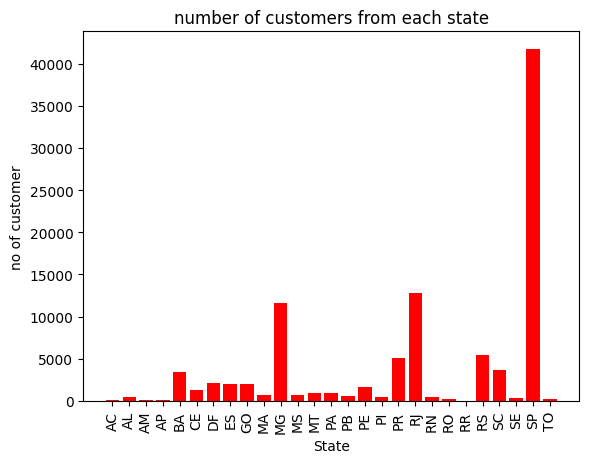

<Figure size 800x300 with 0 Axes>

In [28]:
pl.bar(df["state"],df["Count"], color ='r')
pl.xticks(rotation =90)
pl.xlabel("State")
pl.ylabel("no of customer")
pl.title('number of customers from each state')
pl.figure(figsize=(8,3))
pl.show()

# 6. Calculate the number of orders per month in 2018

In [11]:
query = """
    SELECT monthname(order_purchase_timestamp) AS months, COUNT(order_id) as id
    FROM orders 
    WHERE year(order_purchase_timestamp) = 2018
    GROUP BY months
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["months","no_of_order"])
df


,months,no_of_order
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


# Chart

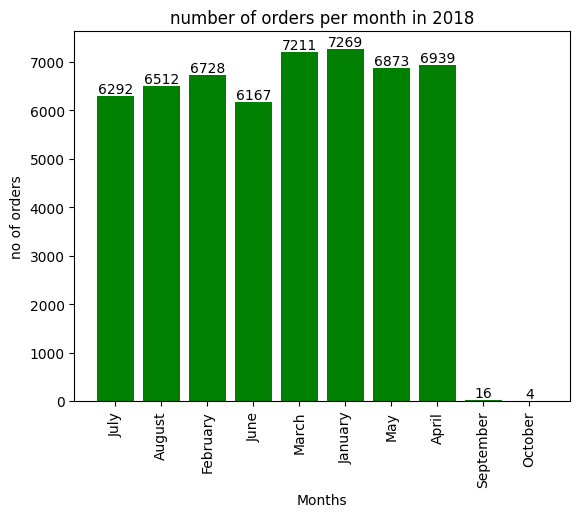

<Figure size 900x400 with 0 Axes>

In [20]:
bars = pl.bar(df["months"],df["no_of_order"], color ='g')
pl.xticks(rotation =90)
pl.xlabel("Months")
pl.ylabel("no of orders")
pl.title('number of orders per month in 2018')
pl.bar_label(bars)
pl.figure(figsize=(9,4))

pl.show()

# 7. Find the average number of products per order, grouped by customer city.

In [53]:
query = """
    with count_per_order as
    (SELECT orders.order_id,orders.customer_id, count(order_items.order_id) as cnt 
    FROM orders 
    JOIN order_items
    ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id,orders.customer_id)
    
    
    SELECT cus.customer_city as city, round(avg(count_per_order.cnt),2) as average
    FROM customers as cus
    JOIN
    count_per_order
    ON cus.customer_id = count_per_order.customer_id
    GROUP BY city
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["city","average"])
df.head()

,city,average
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27


# 8. Calculate the percentage of total revenue contributed by each product category.

In [52]:
query = """    
    SELECT upper(products.product_category) as Category ,
    
    Round(ROUND(SUM(payments.payment_value),2)/ (SELECT SUM(payment_value) FROM payments) *100,2)
    AS Sales_per
    FROM order_items
    
    JOIN products
    
    ON order_items.product_id = products.product_id
    
    JOIN payments
    
    on order_items.order_id = payments.order_id
    GROUP BY Category
    ORDER BY Sales_per DESC
    
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["Category","Sales_per"])
df

,Category,Sales_per
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# 9. Identify the correlation between product price and the number of times a product has been purchased

In [59]:
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
df

#to find corelation
import numpy as py
arr1= df["order_count"]
arr2= df["price"]
py.corrcoef([arr1,arr2])

#results shows the neutral relation no changes in count due to price

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# 10.Calculate the total revenue generated by each seller, and rank them by revenue

In [69]:
query = """    
    SELECT *,dense_rank() over(order by revenue DESC)  as rn
    FROM

    (SELECT sellers.seller_id as seller ,
    
    round(SUM(payments.payment_value),2) as revenue FROM payments
    JOIN order_items
    
    ON payments.order_id = order_items.order_id

    JOIN sellers

    ON order_items.seller_id = sellers.seller_id
    
    GROUP BY seller) 
    as a
    
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["seller","revenue","rank"])
df.head()


,seller,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


# 11. Calculate the moving average of order values for each customer over their order history

In [71]:
query = """    
select customer_id, order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id
order by order_purchase_timestamp rows between 2 preceding and current row) 
as mov_avg
From
(SELECT orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments 
Join
orders
on payments.order_id = orders.order_id) as a
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["id","timestamp","price","moving_avg"])
df.head()


,id,timestamp,price,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# 12. Calculate the cumulative sales per month for each year

In [85]:
query = """    
    SELECT yrs,mon, revenue, sum(revenue) 
    OVER(ORDER BY yrs, mon ) cumulative_sales 
    FROM
   (SELECT year(orders.order_purchase_timestamp) as yrs, month(orders.order_purchase_timestamp) as mon,
    round(sum(payments.payment_value),2) as revenue FROM orders
    join payments
    on orders.order_id = payments.order_id
    group by yrs,mon
    having yrs = 2018
    order by yrs,mon) as a
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["year","months","payment","cumalative_sales"])
df

,year,months,payment,cumalative_sales
0,2018,1,1115004.18,1115004.18
1,2018,2,992463.34,2107467.52
2,2018,3,1159652.12,3267119.64
3,2018,4,1160785.48,4427905.12
4,2018,5,1153982.15,5581887.27
5,2018,6,1023880.50,6605767.77
6,2018,7,1066540.75,7672308.52
7,2018,8,1022425.32,8694733.84
8,2018,9,4439.54,8699173.38
9,2018,10,589.67,8699763.05


# 13. Calculate the year-over-year growth rate of total sales

In [89]:
query = """    

    SELECT yrs,revenue,
    (revenue - lag(revenue,1) over(order by yrs))/ lag(revenue,1) over(order by yrs)
    FROM 
    (SELECT year(orders.order_purchase_timestamp) as yrs,
    round(sum(payments.payment_value),2) as revenue FROM orders
    join payments
    on orders.order_id = payments.order_id
    group by yrs
    order by yrs) as a
"""

cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["year","payment", "growth"])
df

,year,payment,growth
0,2016,59362.34,NaN
1,2017,7249746.73,121.127038
2,2018,8699763.05,0.200009


# 14.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [90]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year

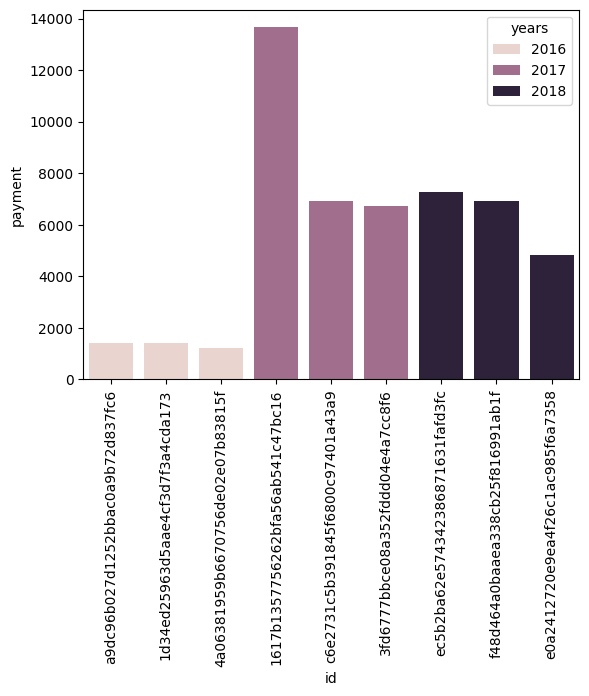

In [106]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""


import seaborn as sns
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()


